In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC


2023-12-27 09:23:04.560396: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-27 09:23:04.712290: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 09:23:04.712335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 09:23:04.712415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 09:23:04.753983: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-27 09:23:04.759203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load Data

In [2]:
import os
import numpy as np


def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.endswith('.npy'):
                    # Load numpy array
                    array = np.load(file_path).flatten()
                    data.append(array)
                    # Label phishing as 1, benign as 0
                    label = 1 if (folder.find('phishing') != -1) else 0
                    labels.append(label)
    return np.array(data), np.array(labels)

# Đường dẫn đến thư mục chứa dữ liệu
phishing_path = 'VisualPhish/phishing_features'
benign_path = 'VisualPhish/trusted_list_features'

# Load dữ liệu
phishing_data, phishing_labels = load_data(phishing_path)
benign_data, benign_labels = load_data(benign_path)



# DCGAN

In [3]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(noise_dim,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Tăng số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1024),  # Tăng thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(512)  # Output layer với 512 units
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        Dense(1024, input_shape=(512,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Giảm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(256),  # Giảm thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')  # Output layer
    ])
    return model

In [4]:
def build_gan(generator, discriminator):
    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

z_dim = 100
batch_size = 32
learning_rate = 0.0002

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))


In [5]:
generator.summary()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [6]:
def train_gan(gan, generator, discriminator, dataset, z_dim, epochs=100):
    for epoch in range(epochs):
        for real_images in dataset:
            # Điều chỉnh kích thước của z dựa trên kích thước thực tế của real_images
            current_batch_size = real_images.shape[0]
            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_images = generator.predict(z, verbose=0)

            combined_images = np.concatenate([real_images, fake_images])
            labels = np.concatenate([np.ones((current_batch_size, 1)), np.zeros((current_batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)

            d_loss = discriminator.train_on_batch(combined_images, labels)

            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_labels = np.ones((current_batch_size, 1))

            g_loss = gan.train_on_batch(z, fake_labels)

        print(f"Epoch: {epoch + 1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Chia dataset thành các batch
dataset = [phishing_data[i:i + batch_size] for i in range(0, len(phishing_data), batch_size)]
if len(dataset[-1]) != batch_size:
    dataset.pop()  # Xóa batch cuối nếu kích thước không phù hợp

# Khởi tạo và huấn luyện mô hình GAN
#train_gan(gan, generator, discriminator, dataset, z_dim, 1000)

# Tái tạo kiến trúc mô hình
generator = build_generator(z_dim)
discriminator = build_discriminator()

# Tải trọng số
generator.load_weights('generator_weights_gan.h5')
discriminator.load_weights('discriminator_weights_gan.h5')
"""

generator.save_weights('generator_weights_gan.h5')
discriminator.save_weights('discriminator_weights_gan.h5')

"""


"\n\ngenerator.save_weights('generator_weights_gan.h5')\ndiscriminator.save_weights('discriminator_weights_gan.h5')\n\n"

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def showFeature(features):
  image = features.reshape(16, 32)
  #print(image.shape)
  #print(image)
  
  plt.subplot(1, 1, 1)  # Tạo subplot
  plt.imshow(image, cmap='viridis')  # Sử dụng viridis làm bảng màu
  plt.title(f'Feature map')
  plt.axis('off')  # Ẩn trục tọa độ

  plt.show()

================ 0 =================
Fake:


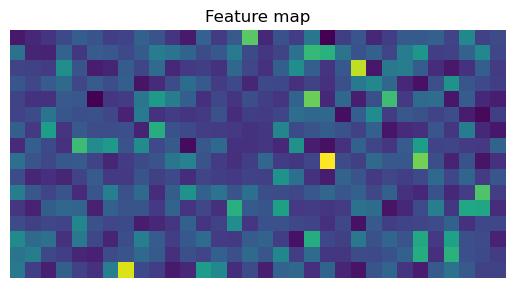

Real:


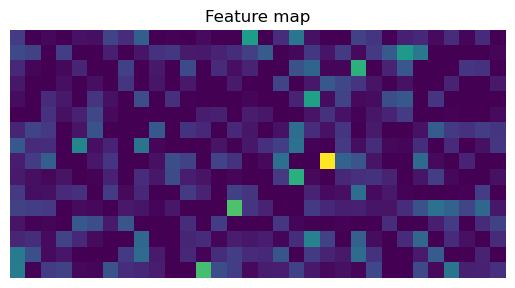

================ 1 =================
Fake:


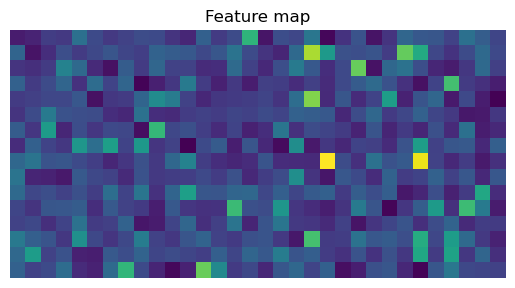

Real:


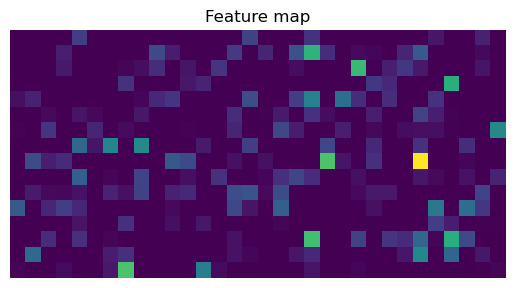

================ 2 =================
Fake:


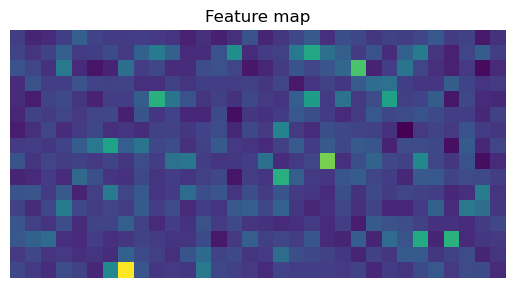

Real:


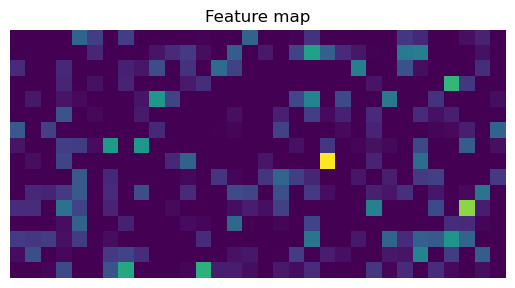

================ 3 =================
Fake:


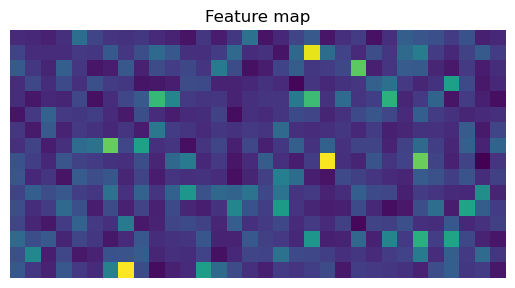

Real:


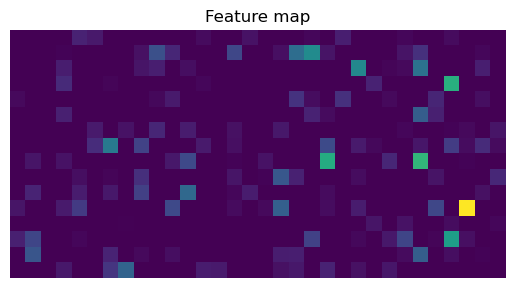

================ 4 =================
Fake:


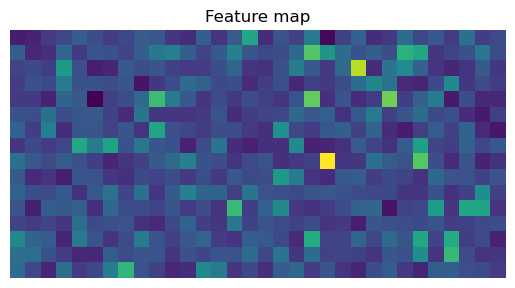

Real:


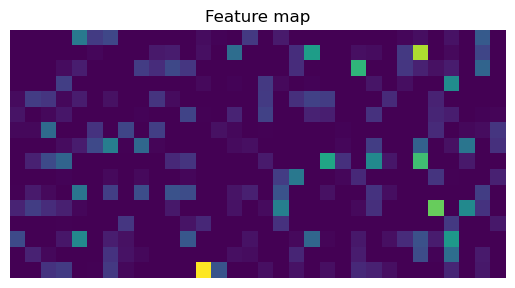

================ 5 =================
Fake:


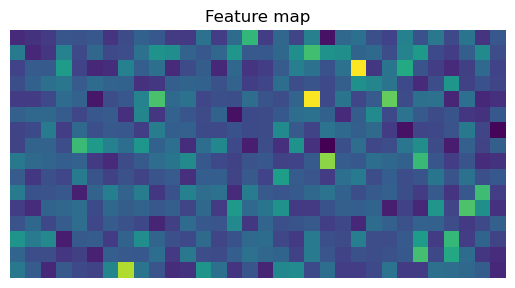

Real:


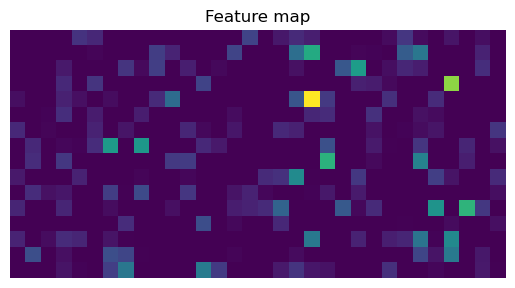

================ 6 =================
Fake:


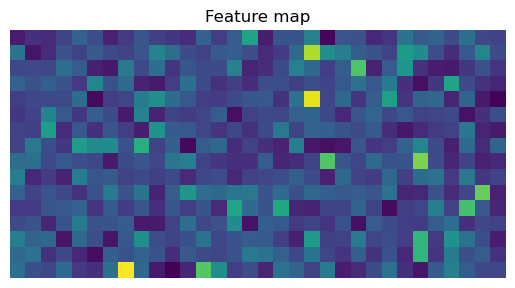

Real:


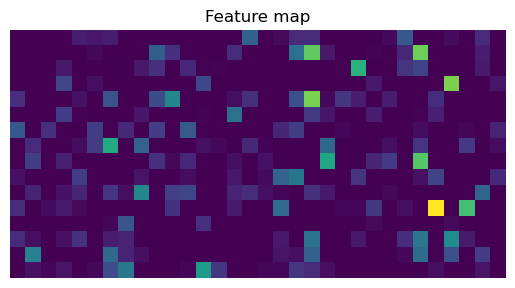

================ 7 =================
Fake:


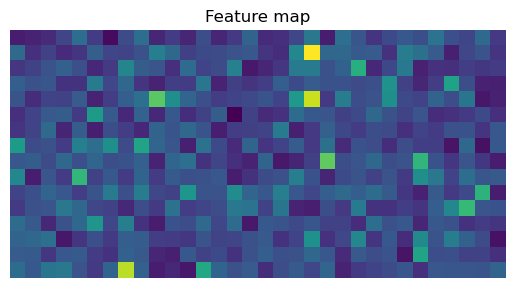

Real:


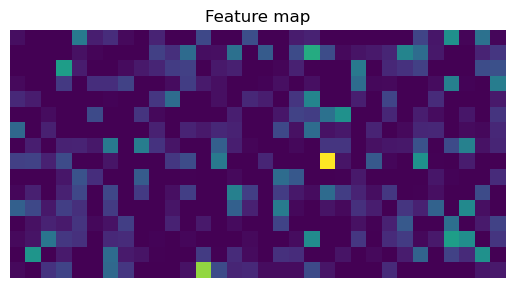

================ 8 =================
Fake:


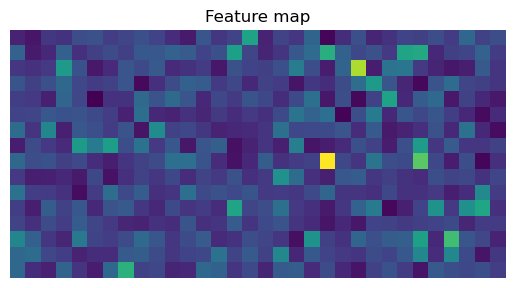

Real:


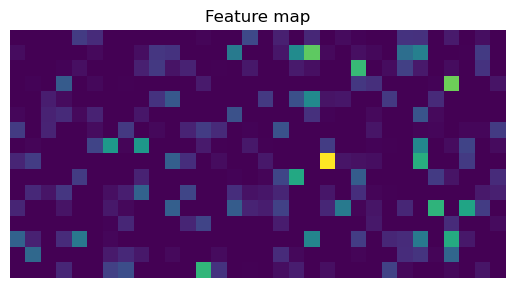

================ 9 =================
Fake:


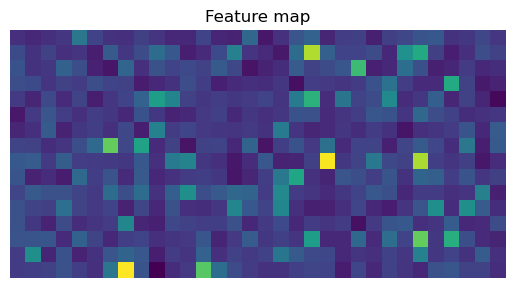

Real:


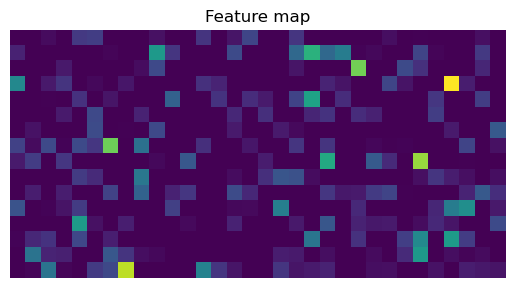

In [8]:
z = np.random.normal(0, 1, (10, z_dim))
fake_images = generator.predict(z, verbose=0)
for i in range(1):
  print("================", i, "=================")
  print("Fake:")
  showFeature(fake_images[i])
  print("Real:")
  showFeature(dataset[0][i])

In [ ]:
"""
@tf.function
def train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):
    # Tạo nhiễu ngẫu nhiên
    noise = tf.random.normal([batch_size, z_dim])

    # GradientTape cho discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # GradientTape cho generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    """


In [9]:
print(benign_data.shape)
print(phishing_data.shape)

(9363, 512)
(1195, 512)


In [26]:
#np.savez('full_ds.npz', X=X, y=y)

In [4]:
loaded_arrays = np.load('full_ds.npz')

# Accessing the arrays
#X = loaded_arrays['X']
#y = loaded_arrays['y']


# DNN

In [6]:

def create_model():
    DNN_model = Sequential([
        Dense(1024, activation='relu', input_shape=(512,)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return DNN_model

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75)

# Chia dữ liệu thành 10 phần

federated_data = []

# Giả sử X, y là dữ liệu của bạn
num_clients = 10

num_samples_per_client = len(X_train) // num_clients

for i in range(num_clients):
    start_idx = i * num_samples_per_client
    end_idx = (i + 1) * num_samples_per_client if i != num_clients - 1 else len(X_train)
    
    X_client = X_train[start_idx:end_idx]
    y_client = y_train[start_idx:end_idx]

    federated_data.append((X_client, y_client))



In [ ]:
while (len(phishing_data) < len(benign_data)):
  print(len(phishing_data), "/", len(benign_data))
  z = np.random.normal(0, 1, (1, z_dim))
  gen_img = generator.predict(z, verbose=0)

  phishing_data = np.vstack((phishing_data, gen_img[0]))
  phishing_labels = np.append(phishing_labels, 1)

print(phishing_data.shape)
print(benign_data.shape)
# Gộp dữ liệu và labels
X = np.concatenate((phishing_data, benign_data), axis=0)
y = np.concatenate((phishing_labels, benign_labels), axis=0)

In [8]:
def preprocessing(X_data, y_data):
    # Chuyển đổi sang TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    dataset = dataset.batch(64) # BatchSize
    return dataset

In [9]:
federated_data_train = [preprocessing(X_client, y_client) for X_client, y_client in federated_data]

In [10]:
def has_weights_changed(old_weights, new_weights, tolerance=1e-5):
    """
    Kiểm tra xem trọng số của mô hình có thay đổi giữa các vòng đào tạo hay không.
    :param old_weights: Trọng số của mô hình từ vòng trước.
    :param new_weights: Trọng số mới của mô hình.
    :param tolerance: Ngưỡng dung sai cho sự thay đổi.
    :return: True nếu có sự thay đổi, ngược lại False.
    """
    for old_layer, new_layer in zip(old_weights, new_weights):
        if np.any(np.abs(new_layer - old_layer) > tolerance):
            return True
    return False

In [12]:

def train_model_on_client(model, client_dataset, epochs=1, epsilon=1.0, delta=1e-5):
    optimizer = Adam(learning_rate=0.0001)
    loss_fn = BinaryCrossentropy()
    accuracy_metric = Accuracy()

    # Giới hạn L2 của gradient, đảm bảo rằng không có gradient nào có norm lớn hơn tham số này
    l2_norm_clip = 1.0

    for epoch in range(epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(client_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)
            
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Clip gradient theo norm L2
            clipped_grads = [tf.clip_by_norm(g, l2_norm_clip) for g in grads]

            # Thêm nhiễu cho differential privacy
            noise_multiplier = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
            noised_grads = [g + noise_multiplier * np.random.normal(size=g.shape) for g in clipped_grads]

            optimizer.apply_gradients(zip(noised_grads, model.trainable_weights))

            accuracy_metric.update_state(y_batch_train, tf.round(tf.sigmoid(logits)))
    """
    # Evaluate the model on the test data
    test_loss, test_accuracy, test_precision, test_recall, test_auc = global_model.evaluate(X_test, y_test)
    
    print("---------------Client----------------")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test AUC: {test_auc}")
    res = model.predict(X_test).flatten()
    print(res)
    cnt = 0
    for x in res:
        if x == 1.0:
            cnt += 1
    print(cnt, "/", len(X_test))
    """
    return model.get_weights(), loss_value, accuracy_metric.result().numpy()
    
def aggregate_weights(client_weights):
    new_weights = [np.mean([client_weights[i][layer] for i in range(len(client_weights))], axis=0) for layer in range(len(client_weights[0]))]
    return new_weights

# Training loop
global_model = create_model()

# Assuming your global model is defined as global_model
global_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
)
previous_weights = global_model.get_weights()

for round_num in range(100):
    print("/////////////////////////////ROUND ", round_num + 1, "///////////////////////////")
    client_weights = []
    losses = []
    accuracies = []

    for client_data in federated_data_train:
        weights, loss, accuracy = train_model_on_client(global_model, client_data, epochs=1)
        client_weights.append(weights)
        losses.append(loss)
        accuracies.append(accuracy)
        if has_weights_changed(weights, previous_weights):
            print("Client i weight thay doi")
        else:
            print("Client i weight khong doi")
    
    # Aggregate the weights and update the global model
    averaged_weights = aggregate_weights(client_weights)
    global_model.set_weights(averaged_weights)

    # Optionally, print out metrics or evaluate on test data
    print(f"Round {round_num + 1}, Loss: {np.mean(losses)}, Accuracy: {np.mean(accuracies)}")
    print(accuracies)

    if has_weights_changed(previous_weights, averaged_weights):
        print(f"Trọng số thay đổi sau vòng {round_num + 1}")
    else:
        print(f"Không có sự thay đổi trong trọng số sau vòng {round_num + 1}")

    # Cập nhật trọng số cho vòng tiếp theo
    previous_weights = averaged_weights
    
    # Evaluate the model on the test data
    test_loss, test_accuracy, test_precision, test_recall, test_auc = global_model.evaluate(X_test, y_test)

    print("------------------------------")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test AUC: {test_auc}")
    res = global_model.predict(X_test).flatten()
    print(res)
    cnt = 0
    for x in res:
        if x == 1.0:
            cnt += 1
    print(cnt, "/", len(X_test))
    
# Evaluate the global model on test data if desired


/////////////////////////////ROUND  1 ///////////////////////////
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Client i weight thay doi
Round 1, Loss: 0.9937813878059387, Accuracy: 0.5020027160644531
[0.50200266, 0.5006676, 0.5153538, 0.49132177, 0.49732977, 0.52870494, 0.5006676, 0.5026702, 0.4919893, 0.4893191]
Trọng số thay đổi sau vòng 1
118/118 [==============================] - 1s 6ms/step - loss: 1.0487 - binary_accuracy: 0.5435 - precision_1: 0.5564 - recall_1: 0.3879 - auc_1: 0.6504
------------------------------
Test Loss: 1.048651933670044
Test Accuracy: 0.5435130596160889
Test Precision: 0.5564142465591431
Test Recall: 0.38793104887008667
Test AUC: 0.6503801345825195
118/118 [==============================] - 1s 5ms/step
[5.4292500e-02 9.1207761e-01 5.3820515e-01 ... 7.9350543e-01 1.4264353e-08
 3

In [18]:
y_pred = global_model.predict(X_test)

118/118 [==============================] - 1s 6ms/step


In [20]:
cnt = 0
for x in y_pred:
  if x > 0.5:
    cnt += 1

print(cnt, "/", len(y_pred))

1867 / 3746
